# NLP to Distinguish Fake Phishing and Spam Job Emails

Problem: The problem that will be tackled in this project is identifying fake or real job opportunity emails. There are many spam emails or phishing emails targetting job seekers and it would be beneficial to distinguish between real or fake job opportunities in emails. This task will be done using natural language processing models such as GRU for its sequential data processing capabilities.

Data: The data contains about 1000 emails, some emails are labeled as fake and some are labeled as real. It is in the form of tabular data. This data was obtained through chatgpt and self prompting.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.saving import register_keras_serializable

## EDA

EDA procedure:
- Import data and look at dimension and structure
- Bar chart to see distribution of labels (0 real or 1 fake)
- Histogram to see distribution of email lengths
- Boxplot to see length of emails with respect to labels
- Bar chart to see the top 20 most common words in emails

In [13]:
# import data

data = pd.read_csv('data/email_data.csv')
print(data.head)

<bound method NDFrame.head of                                                    raw  \
0    Subject: Job Offer for Marketing Manager Posit...   
1    Subject: Congratulations! You've Been Selected...   
2    Subject: Immediate Hiring Opportunity! (No Exp...   
3    Subject: Software Developer Position at Innova...   
4    Subject: Urgent Work-From-Home Opportunity! De...   
..                                                 ...   
983  Subject: Interview Invitation - Data Entry Cle...   
984  Subject: Work Online - Start Immediately Dear ...   
985  Subject: Interview Scheduling - Quality Assura...   
986  Subject: Flexible Remote Work Available Dear J...   
987  Subject: Interview Invitation - Technical Supp...   

                                                  text  label  
0    Subject: Job Offer for Marketing Manager Posit...      0  
1    Subject: Congratulations! You've Been Selected...      0  
2    Subject: Immediate Hiring Opportunity! (No Exp...      1  
3    Subject: Sof

The data has 988 rows and 3 columns each: raw (raw text), text (email body), and label.

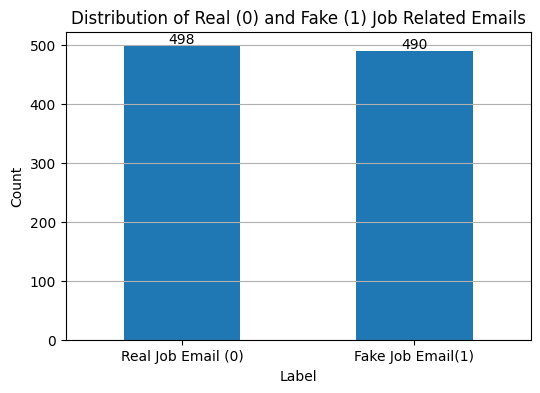

In [14]:
# histogram to see distribution of labels
plt.figure(figsize=(6,4))
label_count = data['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Real (0) and Fake (1) Job Related Emails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1], ['Real Job Email (0)', 'Fake Job Email(1)'], rotation=0)
plt.grid(axis='y')

# add values on top
for p in label_count.patches:
    label_count.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.show()    

The amount of real vs fake job emails are about even so there should not be a lot of bias in the data.

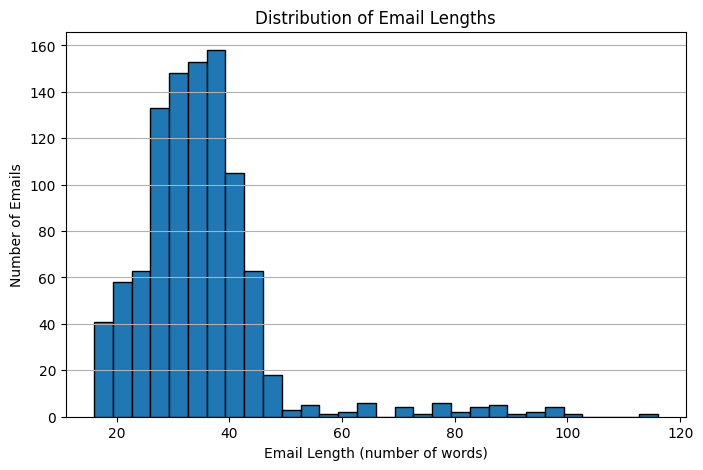

In [15]:
# histogram of email lengths

word_count_list = []
for email in data['text']:
    word_count = email.split() # splits email into list of words
    word_count_list.append(len(word_count))
    
plt.figure(figsize=(8,5))
plt.hist(word_count_list, bins=30, edgecolor='black')
plt.title('Distribution of Email Lengths')
plt.xlabel('Email Length (number of words)')
plt.ylabel('Number of Emails')
plt.grid(axis='y')
plt.show()

Most emails tend to be between the 20 to 40 word range. There are some outliers that are longer, some around 60, some around 100, the highest outlier being almost 120 words long. Since the range seems skewed between the 20-40 range, some normalization methods might need to be employed so that the length does not influence the decision of the GRU model.

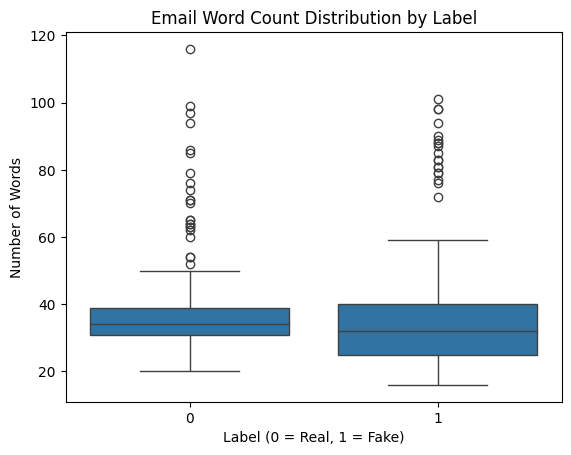

In [16]:
# boxplot to see length distribution by label
sns.boxplot(x=data['label'], y=data['text'].apply(lambda x: len(x.split())))
plt.title("Email Word Count Distribution by Label")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Number of Words")

plt.show()

There are a lot of outliers for both real and fake emails. The first and third quartile gap (edge of blue box) for word length is larger for fake emails than real emails. This gap or spread represents where 50% of the data is ranging in terms of word length. The median line is within the quartile gap is about the same word length for both real and fake emails. The gap for the whiskers representing 1.5 times the iqr of the quartile lines (edge of blue boxes * 1.5). This gap is about even for real emails and has a bigger upper whisker than lower for fake emails. Takeaways are fake emails are not as consistent, some are short and some are long. Real emails are more professional and hover around a certain range more frequently. Since word length median seems to be about the same for real and fake, it might be hard to distinguish solely off word length.

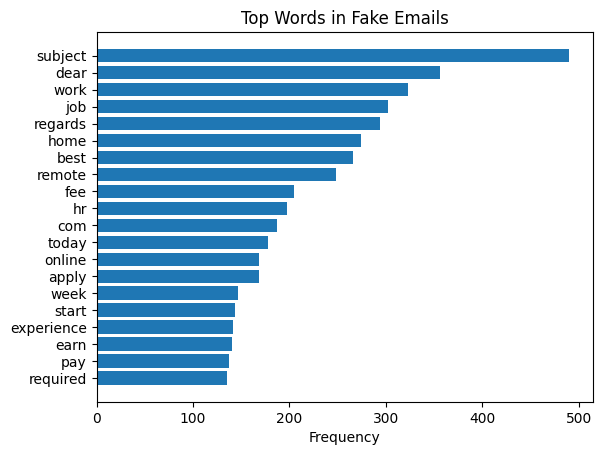

In [17]:
# most common words
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(data[data['label'] == 1]['text'])  # Only fake for example
word_counts = np.asarray(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

# Plot top 20
top_idx = word_counts.argsort()[-20:][::-1]
plt.barh([words[i] for i in top_idx], [word_counts[i] for i in top_idx])
plt.title("Top Words in Fake Emails")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.show()

Subject appears the most but this is due to how the data formatted the subject header, might need to remove that during data cleaning. The words most commonly used seem normal to real job opportunity emails so training using the entire context rather than just individual words might be the best course of action for this classification task.

## Cleaning Data

- Check if all emails have a label
- Check if there are any repeating emails
- 

In [18]:
# check if all emails have a label


In [19]:
# remove unwanted words
data['text'] = data['text'].str.replace(r'\bSubject:\b', '', case=False, regex=True)

# remove special characters, only keeping @ and $. These characters are relevant in some job emails so might be worth keeping.
df['text'] = df['text'].str.replace(r'[^\w\s@$]', '', regex=True)

data.text.head

<bound method NDFrame.head of 0      Subject: Job Offer for Marketing Manager Posit...
1      Subject: Congratulations! You've Been Selected...
2      Subject: Immediate Hiring Opportunity! (No Exp...
3      Subject: Software Developer Position at Innova...
4      Subject: Urgent Work-From-Home Opportunity! De...
                             ...                        
983    Subject: Interview Invitation - Data Entry Cle...
984    Subject: Work Online - Start Immediately Dear ...
985    Subject: Interview Scheduling - Quality Assura...
986    Subject: Flexible Remote Work Available Dear J...
987    Subject: Interview Invitation - Technical Supp...
Name: text, Length: 988, dtype: object>

## Analysis / Results

### Hyperparameter Tuning

## Conclusion